In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [2]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
   
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 

)

0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [4]:
train_images, val_images, train_labels, val_labels = train_test_split(train_data.data, train_data.targets,
                                                                     random_state=0,
                                                                     test_size=0.3)

test_images = test_data.data
test_labels = test_data.targets

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)
train_images_tensor = train_images.clone().detach()/255.0
train_labels_tensor = train_labels.clone().detach()
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
val_images_tensor = val_images.clone().detach()/255.0
val_labels_tensor = val_labels.clone().detach()
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
test_images_tensor = test_images.clone().detach()/255.0

In [6]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [9]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [10]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [11]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    all_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
        all_loss.append(loss.data.detach().cpu())
    avg_loss = np.array(all_loss).mean()
    return avg_loss
    
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = conv_model(data)
        loss += F.cross_entropy(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    loss /= len(data_loader.dataset)
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return np.array(100. * correct / len(data_loader.dataset)), np.array(loss.detach().cpu()).item()


# Training loop

In [12]:
num_epochs = 20
train_loss = []
val_loss = []
best_acc = 0
for n in range(num_epochs):
    tl = train_model(n)
    acc, vl = evaluate(val_loader)
    train_loss.append(tl)
    val_loss.append(vl)
#     if(acc > best_acc):
#         torch.save('./MODELS/model_with_val_acc_'+str(acc))
#         best_acc = acc
        

/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 0 [1600/42000 (4%)]	Loss: 1.180680
Train Epoch: 0 [3200/42000 (8%)]	Loss: 0.663844
Train Epoch: 0 [4800/42000 (11%)]	Loss: 0.410461
Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.471129
Train Epoch: 0 [8000/42000 (19%)]	Loss: 0.204609
Train Epoch: 0 [9600/42000 (23%)]	Loss: 0.751651
Train Epoch: 0 [11200/42000 (27%)]	Loss: 0.086291
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.666510
Train Epoch: 0 [14400/42000 (34%)]	Loss: 0.165606
Train Epoch: 0 [16000/42000 (38%)]	Loss: 0.374895
Train Epoch: 0 [17600/42000 (42%)]	Loss: 0.097258
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.120764
Train Epoch: 0 [20800/42000 (50%)]	Loss: 0.084440
Train Epoch: 0 [22400/42000 (53%)]	Loss: 0.642389
Train Epoch: 0 [24000/42000 (57%)]	Loss: 0.368441
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.109931
Train Epoch: 0 [27200/42000 (65%)]	Loss: 0.397846
Train Epoch: 0 [28800/42000 (69%)]	Loss: 0.329935
Train Epoch: 0 [30400/42000 (72%)]	Loss: 0.069147
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.084445
Train Ep

/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.0603, Val Accuracy: 17665/18000 (98.139%)

Train Epoch: 1 [1600/42000 (4%)]	Loss: 0.118332
Train Epoch: 1 [3200/42000 (8%)]	Loss: 0.086900
Train Epoch: 1 [4800/42000 (11%)]	Loss: 0.222596
Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.324791
Train Epoch: 1 [8000/42000 (19%)]	Loss: 0.070432
Train Epoch: 1 [9600/42000 (23%)]	Loss: 0.046944
Train Epoch: 1 [11200/42000 (27%)]	Loss: 0.128451
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.223792
Train Epoch: 1 [14400/42000 (34%)]	Loss: 0.190215
Train Epoch: 1 [16000/42000 (38%)]	Loss: 0.052646
Train Epoch: 1 [17600/42000 (42%)]	Loss: 0.464779
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.044073
Train Epoch: 1 [20800/42000 (50%)]	Loss: 0.360160
Train Epoch: 1 [22400/42000 (53%)]	Loss: 0.131856
Train Epoch: 1 [24000/42000 (57%)]	Loss: 0.270092
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.082678
Train Epoch: 1 [27200/42000 (65%)]	Loss: 0.179917
Train Epoch: 1 [28800/42000 (69%)]	Loss: 0.054636
Train Epoch: 1 [30400/42000 (72%)]	Loss: 0.0

Train Epoch: 7 [1600/42000 (4%)]	Loss: 0.017835
Train Epoch: 7 [3200/42000 (8%)]	Loss: 0.023083
Train Epoch: 7 [4800/42000 (11%)]	Loss: 0.009661
Train Epoch: 7 [6400/42000 (15%)]	Loss: 0.098639
Train Epoch: 7 [8000/42000 (19%)]	Loss: 0.016822
Train Epoch: 7 [9600/42000 (23%)]	Loss: 0.010330
Train Epoch: 7 [11200/42000 (27%)]	Loss: 0.018567
Train Epoch: 7 [12800/42000 (30%)]	Loss: 0.046945
Train Epoch: 7 [14400/42000 (34%)]	Loss: 0.060548
Train Epoch: 7 [16000/42000 (38%)]	Loss: 0.073809
Train Epoch: 7 [17600/42000 (42%)]	Loss: 0.053497
Train Epoch: 7 [19200/42000 (46%)]	Loss: 0.141632
Train Epoch: 7 [20800/42000 (50%)]	Loss: 0.231933
Train Epoch: 7 [22400/42000 (53%)]	Loss: 0.010570
Train Epoch: 7 [24000/42000 (57%)]	Loss: 0.096011
Train Epoch: 7 [25600/42000 (61%)]	Loss: 0.027522
Train Epoch: 7 [27200/42000 (65%)]	Loss: 0.012525
Train Epoch: 7 [28800/42000 (69%)]	Loss: 0.177409
Train Epoch: 7 [30400/42000 (72%)]	Loss: 0.093854
Train Epoch: 7 [32000/42000 (76%)]	Loss: 0.009253
Train Ep

Train Epoch: 13 [1600/42000 (4%)]	Loss: 0.006717
Train Epoch: 13 [3200/42000 (8%)]	Loss: 0.052964
Train Epoch: 13 [4800/42000 (11%)]	Loss: 0.057419
Train Epoch: 13 [6400/42000 (15%)]	Loss: 0.015152
Train Epoch: 13 [8000/42000 (19%)]	Loss: 0.007682
Train Epoch: 13 [9600/42000 (23%)]	Loss: 0.013262
Train Epoch: 13 [11200/42000 (27%)]	Loss: 0.007308
Train Epoch: 13 [12800/42000 (30%)]	Loss: 0.015141
Train Epoch: 13 [14400/42000 (34%)]	Loss: 0.204154
Train Epoch: 13 [16000/42000 (38%)]	Loss: 0.010684
Train Epoch: 13 [17600/42000 (42%)]	Loss: 0.013564
Train Epoch: 13 [19200/42000 (46%)]	Loss: 0.034653
Train Epoch: 13 [20800/42000 (50%)]	Loss: 0.002518
Train Epoch: 13 [22400/42000 (53%)]	Loss: 0.004549
Train Epoch: 13 [24000/42000 (57%)]	Loss: 0.438805
Train Epoch: 13 [25600/42000 (61%)]	Loss: 0.005375
Train Epoch: 13 [27200/42000 (65%)]	Loss: 0.025190
Train Epoch: 13 [28800/42000 (69%)]	Loss: 0.071867
Train Epoch: 13 [30400/42000 (72%)]	Loss: 0.009600
Train Epoch: 13 [32000/42000 (76%)]	Los


Average Val Loss: 0.0225, Val Accuracy: 17882/18000 (99.344%)

Train Epoch: 19 [1600/42000 (4%)]	Loss: 0.248032
Train Epoch: 19 [3200/42000 (8%)]	Loss: 0.006153
Train Epoch: 19 [4800/42000 (11%)]	Loss: 0.083943
Train Epoch: 19 [6400/42000 (15%)]	Loss: 0.071020
Train Epoch: 19 [8000/42000 (19%)]	Loss: 0.000711
Train Epoch: 19 [9600/42000 (23%)]	Loss: 0.452359
Train Epoch: 19 [11200/42000 (27%)]	Loss: 0.004201
Train Epoch: 19 [12800/42000 (30%)]	Loss: 0.086999
Train Epoch: 19 [14400/42000 (34%)]	Loss: 0.002909
Train Epoch: 19 [16000/42000 (38%)]	Loss: 0.425541
Train Epoch: 19 [17600/42000 (42%)]	Loss: 0.067515
Train Epoch: 19 [19200/42000 (46%)]	Loss: 0.008074
Train Epoch: 19 [20800/42000 (50%)]	Loss: 0.002190
Train Epoch: 19 [22400/42000 (53%)]	Loss: 0.075114
Train Epoch: 19 [24000/42000 (57%)]	Loss: 0.126155
Train Epoch: 19 [25600/42000 (61%)]	Loss: 0.001762
Train Epoch: 19 [27200/42000 (65%)]	Loss: 0.121859
Train Epoch: 19 [28800/42000 (69%)]	Loss: 0.001654
Train Epoch: 19 [30400/420

In [13]:
import pandas as pd
df = pd.DataFrame({ 'train loss':train_loss, 'val loss':val_loss})

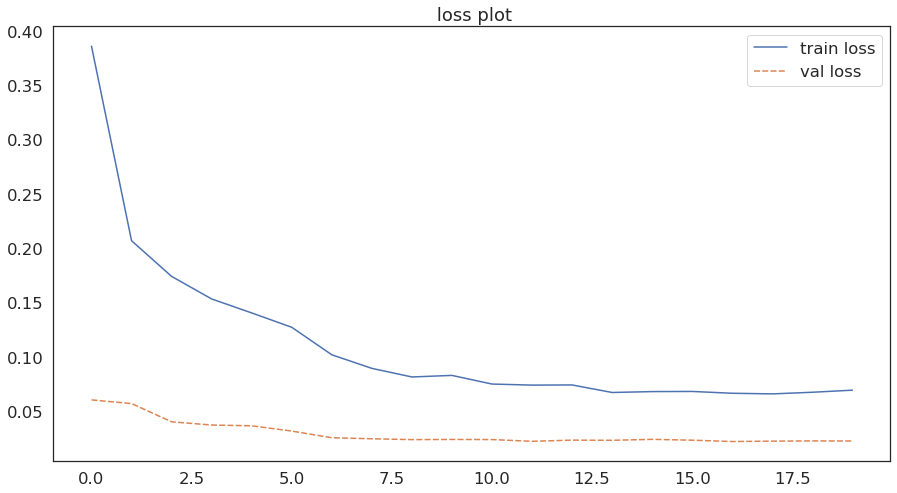

In [34]:
import seaborn as sns
sns.set(rc={'figure.figsize':((15,8))}, font_scale = 1.5)
sns.set_style('white')

a = sns.lineplot(data=df)
plt.title( " loss plot")
plt.savefig('loss_plot.png', dpi=300)

In [22]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            

        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds


In [23]:
test_set_preds = make_predictions(test_loader)

In [24]:
preds = np.array(test_set_preds).flatten()
labels = np.array(test_labels)

In [25]:
acc = np.array(preds == labels).astype(int).mean()

In [26]:
df2 = pd.DataFrame({'True values': labels, 'Predicted values':preds})

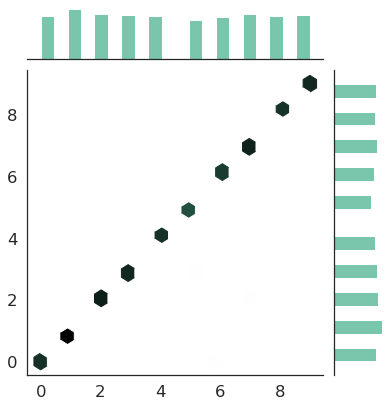

In [35]:
import seaborn as sns
sns.jointplot(x=labels, y= preds, kind='hex',color="#4CB391")
plt.savefig('Correlation_plot.png', dpi=300)